# Full Model from Severson

Inspired by: https://codeocean.com/capsule/2426768/tree/v2



Loaded main dataset with 99006654 rows and 16 columns
Loaded secondary dataset with 31707805 rows and 16 columns
Merged dataset has 130714459 rows and 16 columns
Preprocessed 169 battery cells

Evaluating model5

Processing split: model5

Results for model5:
Train RMSE: 128 cycles
Test RMSE: 93 cycles
Train MAPE: 12.0%
Test MAPE: 9.8%
Number of training cells: 126
Number of test cells: 43


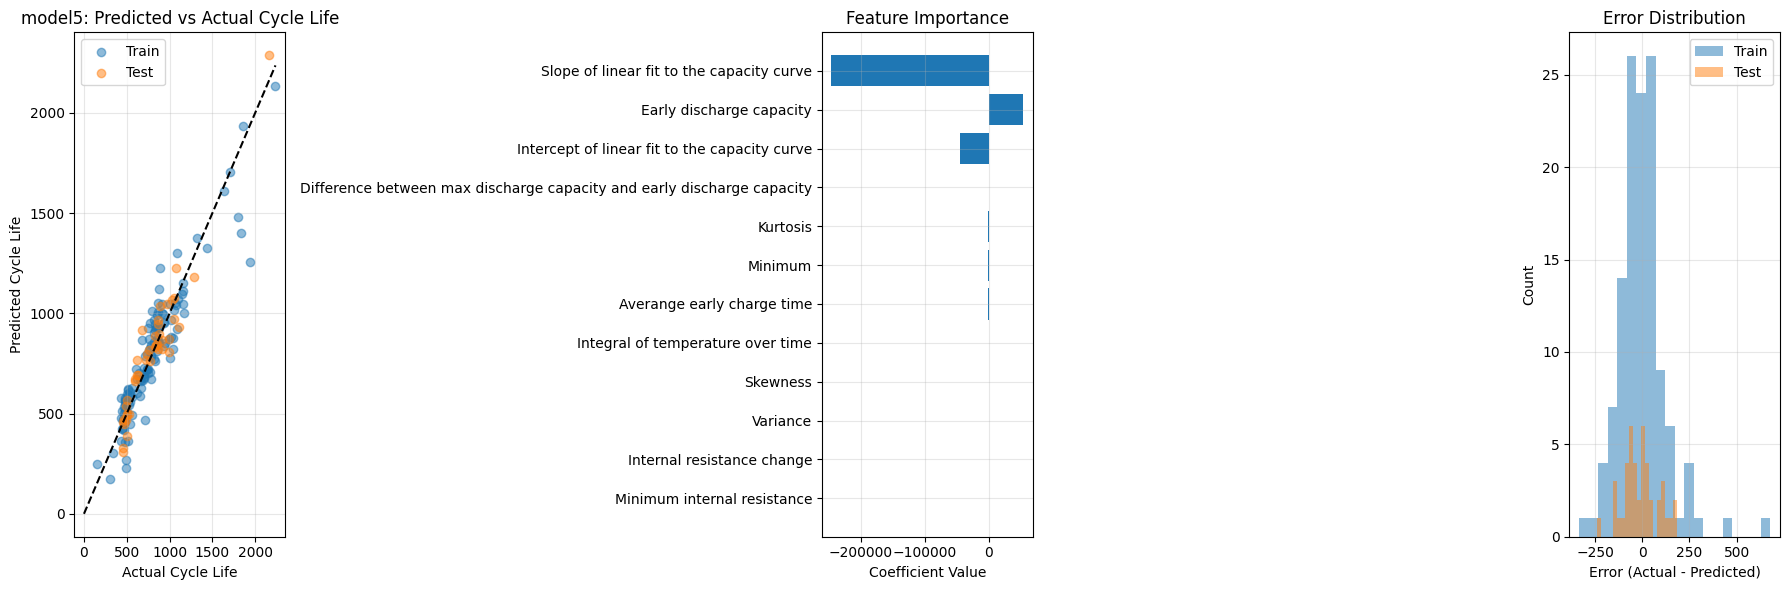




SUMMARY OF RESULTS
    Split  Train RMSE  Test RMSE  Train MAPE (%)  Test MAPE (%)  Train Size  \
0  model5  127.792451  92.666459       11.991359        9.75634         126   

   Test Size  
0         43  


<Figure size 1200x800 with 0 Axes>

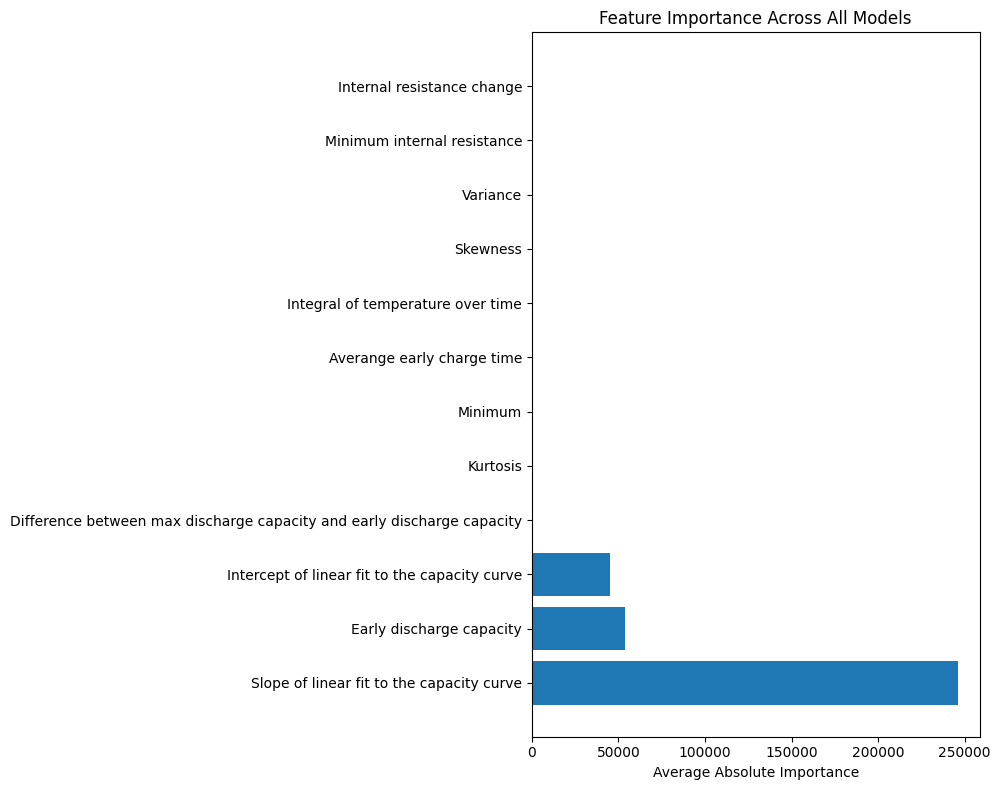

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


class Registry:
    def __init__(self):
        self.registry = {}

    def register(self):
        def decorator(cls):
            self.registry[cls.__name__] = cls
            return cls

        return decorator

    def get(self, name):
        return self.registry.get(name)


FEATURE_EXTRACTORS = Registry()


# Define Battery Data classes
class CycleData:
    def __init__(self, data_dict):
        self.cycle_index = data_dict.get("cycle_index")
        self.discharge_capacity_in_Ah = data_dict.get("discharge_capacity")
        self.voltage_in_V = data_dict.get("voltage")
        self.current_in_A = data_dict.get("current")
        self.temperature_in_C = data_dict.get("temperature")
        self.time_in_s = data_dict.get("time")
        self.internal_resistance_in_ohm = data_dict.get("internal_resistance")
        self.additional_data = data_dict.get("additional_data", {})


class BatteryData:
    def __init__(self, cell_key, cycle_life, min_voltage_limit_in_V, max_voltage_limit_in_V):
        self.cell_key = cell_key
        self.cycle_life = cycle_life
        self.min_voltage_limit_in_V = min_voltage_limit_in_V
        self.max_voltage_limit_in_V = max_voltage_limit_in_V
        self.cycle_data = {}  # Maps cycle_index to CycleData

    def add_cycle_data(self, cycle_index, cycle_data):
        self.cycle_data[cycle_index] = cycle_data


def interpolate(x, y, interp_dims, xs=0, xe=1):
    """Interpolate function from original implementation"""
    if len(x) <= 2:
        return np.zeros(interp_dims)
    func = interp1d(x, y, bounds_error=False)
    new_x = np.linspace(xs, xe, interp_dims)
    return func(new_x)


def _get_Qdlin(I, V, Q, min_V, max_V):
    """Calculate Qdlin following the original implementation"""
    eps = 1e-1
    I, V, Q = np.array(I), np.array(V), np.array(Q)

    discharge_mask = I < -eps
    if sum(discharge_mask) <= 2:
        return np.zeros(1000)

    y = interpolate(V[discharge_mask], Q[discharge_mask], 1000, xs=min_V, xe=max_V)
    return y[::-1]


def get_Qdlin(cell_data, cycle_data, use_precalculated=False):
    """Get Qdlin with option to use precalculated values"""
    if "Qdlin" in cycle_data.additional_data and use_precalculated:
        return np.array(cycle_data.additional_data["Qdlin"])
    return _get_Qdlin(
        cycle_data.current_in_A,
        cycle_data.voltage_in_V,
        cycle_data.discharge_capacity_in_Ah,
        cell_data.min_voltage_limit_in_V,
        cell_data.max_voltage_limit_in_V,
    )


def smooth(x, window_size=10, sigma=3):
    """Smooth function from original implementation"""
    res = np.empty_like(x)
    meds = np.empty_like(x)
    for i in range(len(x)):
        low = max(0, i - window_size)
        high = min(len(x), i + window_size + 1)
        meds[i] = np.median(x[low:high])
    base = np.std(np.abs(x - meds))
    for i in range(len(x)):
        if np.abs(meds[i] - x[i]) > base * sigma:
            res[i] = meds[i]
        else:
            res[i] = x[i]
    return meds


def get_charge_time(I, t):
    """Calculate charge time"""
    res = 0.0
    for i in range(1, len(I)):
        if I[i] < 0:
            res += t[i] - t[i - 1]
    return res


class BaseFeatureExtractor:
    def __init__(self):
        pass

    def process_cell(self, cell_data):
        """Process a single cell to extract features"""
        raise NotImplementedError("Subclasses must implement this method")


class SeversonFeatureExtractor(BaseFeatureExtractor):
    def __init__(
        self,
        interp_dims=1000,
        critical_cycles=None,
        smooth_diff_qdlin=True,
        use_precalculated_qdlin=False,
    ):
        BaseFeatureExtractor.__init__(self)
        critical_cycles = critical_cycles or [1, 9, 99]
        self.interp_dims = interp_dims
        self.critical_cycles = sorted(critical_cycles)
        self.smooth_diff_qdlin = smooth_diff_qdlin
        self.use_precalculated_qdlin = use_precalculated_qdlin

    def get_features(self, cell_data, feature_lists):
        """Extract features from cell data based on feature list"""
        # Check if critical cycles exist in the data
        if not all(cycle in cell_data.cycle_data for cycle in self.critical_cycles):
            available_cycles = sorted(list(cell_data.cycle_data.keys()))
            print(
                f"Warning: Not all critical cycles {self.critical_cycles} available for {cell_data.cell_key}. Available: {available_cycles}"
            )
            if len(available_cycles) >= 3:
                self.critical_cycles = [
                    available_cycles[0],
                    available_cycles[len(available_cycles) // 2],
                    available_cycles[-1],
                ]
            else:
                self.critical_cycles = [available_cycles[0]] * 3

        early_cycle = cell_data.cycle_data[self.critical_cycles[1]]
        late_cycle = cell_data.cycle_data[self.critical_cycles[2]]

        early_qdlin = get_Qdlin(cell_data, early_cycle, self.use_precalculated_qdlin)
        late_qdlin = get_Qdlin(cell_data, late_cycle, self.use_precalculated_qdlin)

        diff_qdlin = late_qdlin - early_qdlin
        if self.smooth_diff_qdlin:
            diff_qdlin = smooth(diff_qdlin)
        diff_qdlin = torch.from_numpy(diff_qdlin).float()
        diff_qdlin = diff_qdlin[~torch.isnan(diff_qdlin)]
        if len(diff_qdlin) <= 1:
            print(f"Warning: Qdlin is all nan for {cell_data.cell_key}!")
            diff_qdlin = torch.zeros(10)

        results = []
        for feature in feature_lists:
            value = self.get_feature(cell_data, diff_qdlin, feature)
            if value is not None:
                results.append(value)
            else:
                results.append(0.0)

        results = torch.tensor(results).float()

        results[torch.isnan(results) | torch.isinf(results)] = 0.0

        return results

    def get_feature(self, cell_data, diff_qdlin, feature):
        """Get a specific feature value"""
        eps = 1e-8

        Qd_features = {
            "Minimum": lambda x: (x.min().abs() + eps).log10(),
            "Variance": lambda x: (x.var() + eps).log10(),
            "Skewness": lambda x: (
                ((x - x.mean()) ** 3).mean().abs() / (x.std() ** 3 + eps) + eps
            ).log10(),
            "Kurtosis": lambda x: (
                ((x - x.mean()) ** 4).mean() / (x.var() ** 2 + eps) + eps
            ).log10(),
        }
        if feature in Qd_features:
            result = Qd_features[feature](diff_qdlin).item()
            return result

        Qd = []
        for cycle_idx in sorted(cell_data.cycle_data.keys()):
            if cycle_idx >= self.critical_cycles[0] and cycle_idx <= self.critical_cycles[2]:
                cycle_data = cell_data.cycle_data[cycle_idx]
                if cycle_data.discharge_capacity_in_Ah:
                    Qd.append(max(cycle_data.discharge_capacity_in_Ah))

        if not Qd:
            return 0.0

        if feature == "Early discharge capacity":
            return Qd[0] if Qd else 0.0

        if feature == "Difference between max discharge capacity and early discharge capacity":
            return max(Qd) - Qd[0] if Qd else 0.0

        if feature == "Slope of linear fit to the capacity curve":
            if len(Qd) <= 1:
                return 0.0
            model = LinearRegression()
            x, y = np.arange(len(Qd))[:, None], np.array(Qd)
            model.fit(x, y)
            return model.coef_[0]

        if feature == "Intercept of linear fit to the capacity curve":
            if len(Qd) <= 1:
                return 0.0
            model = LinearRegression()
            x, y = np.arange(len(Qd))[:, None], np.array(Qd)
            model.fit(x, y)
            return model.intercept_

        # Other features
        if feature == "Averange early charge time":
            charge_time = []
            for cycle in range(4):
                if cycle in cell_data.cycle_data:
                    cycle_data = cell_data.cycle_data[cycle]
                    if cycle_data.current_in_A is not None and cycle_data.time_in_s is not None:
                        charge_time.append(
                            get_charge_time(
                                np.array(cycle_data.current_in_A), np.array(cycle_data.time_in_s)
                            )
                        )
            result = np.mean(charge_time) if charge_time else 0.0
            return np.log(result + eps)

        if feature == "Integral of temperature over time":
            res, counts = 0.0, 0
            for cycle in range(self.critical_cycles[0], self.critical_cycles[2] + 1):
                if cycle in cell_data.cycle_data:
                    cycle_data = cell_data.cycle_data[cycle]
                    if cycle_data.temperature_in_C is not None:
                        T = [x for x in cycle_data.temperature_in_C if not np.isnan(x)]
                        if T:
                            res += np.mean(T)
                            counts += 1
            if counts > 0:
                res /= counts
            result = np.log(res + eps)
            return result

        if feature == "Minimum internal resistance":
            ir = []
            for cycle in range(self.critical_cycles[0], self.critical_cycles[2] + 1):
                if cycle in cell_data.cycle_data:
                    cycle_data = cell_data.cycle_data[cycle]
                    if cycle_data.internal_resistance_in_ohm is not None:
                        ir.append(cycle_data.internal_resistance_in_ohm)
            return np.min(ir) if ir else 0.0

        if feature == "Internal resistance change":
            if (
                self.critical_cycles[0] in cell_data.cycle_data
                and self.critical_cycles[2] in cell_data.cycle_data
            ):
                early_ir = cell_data.cycle_data[self.critical_cycles[0]].internal_resistance_in_ohm
                late_ir = cell_data.cycle_data[self.critical_cycles[2]].internal_resistance_in_ohm
                if early_ir is not None and late_ir is not None:
                    return late_ir - early_ir
            return 0.0


@FEATURE_EXTRACTORS.register()
class FullModelFeatureExtractor(SeversonFeatureExtractor):
    def process_cell(self, cell_data):
        """Process a cell with all features"""
        features = [
            "Minimum",
            "Variance",
            "Skewness",
            "Kurtosis",
            "Slope of linear fit to the capacity curve",
            "Intercept of linear fit to the capacity curve",
            "Early discharge capacity",
            "Difference between max discharge capacity and early discharge capacity",
            "Averange early charge time",
            "Integral of temperature over time",
            "Minimum internal resistance",
            "Internal resistance change",
        ]
        return self.get_features(cell_data, features)


def load_battery_data(file_path):
    """Load battery data from CSV file"""
    df = pd.read_csv(file_path)
    print(f"Loaded data with {df.shape[0]} rows and {df.shape[1]} columns")

    expected_columns = [
        "cell_key",
        "cycle_number",
        "voltage",
        "current",
        "discharge_capacity",
        "cycle_life",
        "temperature",
        "time",
    ]
    missing_columns = [col for col in expected_columns if col not in df.columns]

    if missing_columns:
        print(f"Warning: Missing expected columns: {missing_columns}")

    return df


def load_and_merge_data():
    """Load and merge data from main and secondary datasets"""
    main_df = pd.read_csv("../beep_main_ds_quartiles.csv")
    print(f"Loaded main dataset with {main_df.shape[0]} rows and {main_df.shape[1]} columns")

    secondary_df = pd.read_csv("../test_secondary_beep_dataset_quartile_charge_policy.csv")
    print(
        f"Loaded secondary dataset with {secondary_df.shape[0]} rows and {secondary_df.shape[1]} columns"
    )

    df = pd.concat([main_df, secondary_df], ignore_index=True)
    print(f"Merged dataset has {df.shape[0]} rows and {df.shape[1]} columns")

    return df


def preprocess_battery_data(df):
    """Convert raw DataFrame into BatteryData objects"""
    cell_groups = df.groupby("cell_key")
    battery_data_dict = {}

    for cell_key, cell_df in cell_groups:
        cycle_life = cell_df["cycle_life"].iloc[0]
        min_voltage = cell_df["voltage"].min()
        max_voltage = cell_df["voltage"].max()

        battery_data = BatteryData(cell_key, cycle_life, min_voltage, max_voltage)

        cycle_groups = cell_df.groupby("cycle_number")

        for cycle_number, cycle_df in cycle_groups:
            cycle_dict = {
                "cycle_index": cycle_number,
                "voltage": cycle_df["voltage"].tolist(),
                "current": cycle_df["current"].tolist(),
                "discharge_capacity": cycle_df["discharge_capacity"].tolist(),
            }

            if "temperature" in cycle_df.columns:
                cycle_dict["temperature"] = cycle_df["temperature"].tolist()
            if "time" in cycle_df.columns:
                cycle_dict["time"] = cycle_df["time"].tolist()
            if "internal_resistance" in cycle_df.columns:
                cycle_dict["internal_resistance"] = cycle_df["internal_resistance"].iloc[0]

            cycle_data = CycleData(cycle_dict)
            battery_data.add_cycle_data(cycle_number, cycle_data)

        battery_data_dict[cell_key] = battery_data

    return battery_data_dict


def get_cell_splits():
    """Return the train/test splits for each model"""
    splits = {
        "model5": {
            "train": [
                "b1c0",
                "b1c11",
                "b1c16",
                "b1c17",
                "b1c18",
                "b1c2",
                "b1c20",
                "b1c21",
                "b1c23",
                "b1c24",
                "b1c25",
                "b1c26",
                "b1c3",
                "b1c30",
                "b1c32",
                "b1c35",
                "b1c36",
                "b1c37",
                "b1c38",
                "b1c39",
                "b1c4",
                "b1c41",
                "b1c43",
                "b2c0",
                "b2c1",
                "b2c11",
                "b2c13",
                "b2c14",
                "b2c17",
                "b2c18",
                "b2c2",
                "b2c24",
                "b2c25",
                "b2c27",
                "b2c28",
                "b2c29",
                "b2c3",
                "b2c30",
                "b2c33",
                "b2c36",
                "b2c38",
                "b2c39",
                "b2c4",
                "b2c40",
                "b2c41",
                "b2c42",
                "b2c45",
                "b2c46",
                "b2c47",
                "b2c6",
                "b3c1",
                "b3c11",
                "b3c12",
                "b3c13",
                "b3c16",
                "b3c17",
                "b3c18",
                "b3c19",
                "b3c20",
                "b3c21",
                "b3c27",
                "b3c29",
                "b3c30",
                "b3c34",
                "b3c35",
                "b3c36",
                "b3c39",
                "b3c41",
                "b3c45",
                "b3c6",
                "b3c9",
                "b5cl0",
                "b5cl1",
                "b5cl10",
                "b5cl11",
                "b5cl12",
                "b5cl13",
                "b5cl14",
                "b5cl16",
                "b5cl17",
                "b5cl18",
                "b5cl2",
                "b5cl20",
                "b5cl21",
                "b5cl22",
                "b5cl23",
                "b5cl24",
                "b5cl26",
                "b5cl28",
                "b5cl3",
                "b5cl31",
                "b5cl34",
                "b5cl35",
                "b5cl38",
                "b5cl4",
                "b5cl40",
                "b5cl43",
                "b5cl44",
                "b5cl6",
                "b5cl8",
                "b5cl9",
                "b1c14",
                "b1c19",
                "b1c34",
                "b1c42",
                "b1c5",
                "b2c10",
                "b2c22",
                "b2c32",
                "b2c37",
                "b2c43",
                "b2c44",
                "b2c5",
                "b3c0",
                "b3c15",
                "b3c22",
                "b3c24",
                "b3c28",
                "b3c31",
                "b3c38",
                "b3c40",
                "b3c44",
                "b3c7",
                "b5cl32",
                "b5cl41",
                "b5cl7",
            ],
            "test": [
                "b1c1",
                "b1c15",
                "b1c27",
                "b1c28",
                "b1c29",
                "b1c31",
                "b1c33",
                "b1c40",
                "b1c44",
                "b1c45",
                "b1c6",
                "b1c7",
                "b1c9",
                "b2c12",
                "b2c19",
                "b2c20",
                "b2c21",
                "b2c23",
                "b2c26",
                "b2c31",
                "b2c34",
                "b2c35",
                "b3c10",
                "b3c14",
                "b3c25",
                "b3c26",
                "b3c3",
                "b3c33",
                "b3c4",
                "b3c5",
                "b3c8",
                "b5cl15",
                "b5cl19",
                "b5cl25",
                "b5cl27",
                "b5cl29",
                "b5cl30",
                "b5cl33",
                "b5cl36",
                "b5cl37",
                "b5cl39",
                "b5cl42",
                "b5cl5",
            ],
        }
    }

    return splits


def evaluate_model(split_name, train_cells, test_cells, battery_data_dict, feature_extractor):
    """Evaluate model on a train/test split"""
    print(f"\nProcessing split: {split_name}")

    X_train, y_train = [], []
    for cell_key in train_cells:
        if cell_key in battery_data_dict:
            cell_data = battery_data_dict[cell_key]

            features = feature_extractor.process_cell(cell_data)

            if isinstance(features, torch.Tensor):
                features = features.detach().numpy()

            if not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
                X_train.append(features)
                y_train.append(cell_data.cycle_life)
            else:
                print(f"Skipping train cell {cell_key} due to NaN/inf features")
        else:
            print(f"Train cell {cell_key} not found in data")

    X_test, y_test = [], []
    for cell_key in test_cells:
        if cell_key in battery_data_dict:
            cell_data = battery_data_dict[cell_key]

            features = feature_extractor.process_cell(cell_data)

            if isinstance(features, torch.Tensor):
                features = features.detach().numpy()
            if not np.any(np.isnan(features)) and not np.any(np.isinf(features)):
                X_test.append(features)
                y_test.append(cell_data.cycle_life)
            else:
                print(f"Skipping test cell {cell_key} due to NaN/inf features")
        else:
            print(f"Test cell {cell_key} not found in data")

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Not enough data for modeling split {split_name}")
        return None

    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    feature_names = [
        "Minimum",
        "Variance",
        "Skewness",
        "Kurtosis",
        "Slope of linear fit to the capacity curve",
        "Intercept of linear fit to the capacity curve",
        "Early discharge capacity",
        "Difference between max discharge capacity and early discharge capacity",
        "Averange early charge time",
        "Integral of temperature over time",
        "Minimum internal resistance",
        "Internal resistance change",
    ]

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    if len(y_train) > 0 and len(y_pred_train) > 0:
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        train_mape = mean_absolute_percentage_error(y_train, y_pred_train) * 100
    else:
        train_rmse = np.nan
        train_mape = np.nan

    if len(y_test) > 0 and len(y_pred_test) > 0:
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        test_mape = mean_absolute_percentage_error(y_test, y_pred_test) * 100
    else:
        test_rmse = np.nan
        test_mape = np.nan

    results = {
        "train_rmse": train_rmse,
        "test_rmse": test_rmse,
        "train_mape": train_mape,
        "test_mape": test_mape,
        "n_train": len(y_train),
        "n_test": len(y_test),
        "coef": model.coef_,
        "feature_names": feature_names[: len(model.coef_)],
        "feature_importances": dict(zip(feature_names[: len(model.coef_)], model.coef_)),
    }

    print(f"\nResults for {split_name}:")
    print(f"Train RMSE: {results['train_rmse']:.0f} cycles")
    print(f"Test RMSE: {results['test_rmse']:.0f} cycles")
    print(f"Train MAPE: {results['train_mape']:.1f}%")
    print(f"Test MAPE: {results['test_mape']:.1f}%")
    print(f"Number of training cells: {results['n_train']}")
    print(f"Number of test cells: {results['n_test']}")

    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.scatter(y_train, y_pred_train, alpha=0.5, label="Train")
    plt.scatter(y_test, y_pred_test, alpha=0.5, label="Test")
    max_cycles = max(max(y_train), max(y_test))
    plt.plot([0, max_cycles], [0, max_cycles], "k--")
    plt.xlabel("Actual Cycle Life")
    plt.ylabel("Predicted Cycle Life")
    plt.title(f"{split_name}: Predicted vs Actual Cycle Life")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Plot 2: Feature Importances
    plt.subplot(1, 3, 2)
    feature_names = results["feature_names"]
    importances = results["coef"]

    sorted_idx = np.argsort(np.abs(importances))
    plt.barh([feature_names[i] for i in sorted_idx], [importances[i] for i in sorted_idx])
    plt.title("Feature Importance")
    plt.xlabel("Coefficient Value")
    plt.grid(True, alpha=0.3)

    # Plot 3: Error Distribution
    plt.subplot(1, 3, 3)
    train_errors = y_train - y_pred_train
    test_errors = y_test - y_pred_test

    plt.hist(train_errors, alpha=0.5, bins=20, label="Train")
    plt.hist(test_errors, alpha=0.5, bins=20, label="Test")
    plt.xlabel("Error (Actual - Predicted)")
    plt.ylabel("Count")
    plt.title("Error Distribution")
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    return results


if __name__ == "__main__":
    # 1. Load and merge the data from both files
    raw_df = load_and_merge_data()

    # 2. Preprocess the data
    battery_data_dict = preprocess_battery_data(raw_df)
    print(f"Preprocessed {len(battery_data_dict)} battery cells")

    # 3. Create the feature extractor
    feature_extractor = FullModelFeatureExtractor(
        interp_dims=1000,
        critical_cycles=[1, 10, 100],  # Use cycles 1, 10, and 100 as the critical cycles
        smooth_diff_qdlin=True,
    )

    # 4. Get the cell splits
    splits = get_cell_splits()

    # 5. Run the model for each split
    results = {}
    for split_name, split_data in splits.items():
        print(f"\n{'='*50}")
        print(f"Evaluating {split_name}")
        print(f"{'='*50}")

        split_result = evaluate_model(
            split_name,
            split_data["train"],
            split_data["test"],
            battery_data_dict,
            feature_extractor,
        )

        if split_result:
            results[split_name] = split_result

    # 6. Summary of all results
    print("\n\n")
    print("=" * 80)
    print("SUMMARY OF RESULTS")
    print("=" * 80)

    result_df = pd.DataFrame({
        "Split": list(results.keys()),
        "Train RMSE": [results[k]["train_rmse"] for k in results],
        "Test RMSE": [results[k]["test_rmse"] for k in results],
        "Train MAPE (%)": [results[k]["train_mape"] for k in results],
        "Test MAPE (%)": [results[k]["test_mape"] for k in results],
        "Train Size": [results[k]["n_train"] for k in results],
        "Test Size": [results[k]["n_test"] for k in results],
    })

    print(result_df)

    # 7. Plot overall feature importance across all models
    if results:
        plt.figure(figsize=(12, 8))

        all_importances = {}

        for split_name, result in results.items():
            for feature, importance in result["feature_importances"].items():
                if feature not in all_importances:
                    all_importances[feature] = []
                all_importances[feature].append(importance)

        avg_importances = {
            feature: np.mean(np.abs(importances))
            for feature, importances in all_importances.items()
        }

        sorted_features = sorted(
            avg_importances.keys(), key=lambda x: avg_importances[x], reverse=True
        )

        plt.figure(figsize=(10, 8))
        y_pos = np.arange(len(sorted_features))
        plt.barh(y_pos, [avg_importances[f] for f in sorted_features])
        plt.yticks(y_pos, sorted_features)
        plt.xlabel("Average Absolute Importance")
        plt.title("Feature Importance Across All Models")
        plt.tight_layout()
        plt.show()